In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Style transfer

In [2]:
from fastai.conv_learner import *
from pathlib import Path
from scipy import ndimage
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('data/cyclic/sail_pict2watercolor')
PATH_TRN = PATH/'trainB'

In [4]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

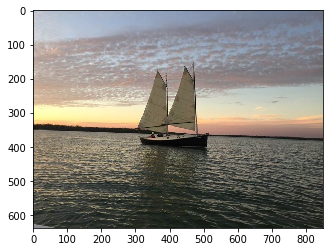

In [5]:
img_fn = PATH_TRN/'_26169029_1.jpg'
img = open_image(img_fn)
plt.imshow(img);

In [6]:
sz=288
# sz=144

In [7]:
trn_tfms,val_tfms = tfms_from_model(vgg16, sz)
img_tfm = val_tfms(img)
img_tfm.shape

(3, 288, 288)

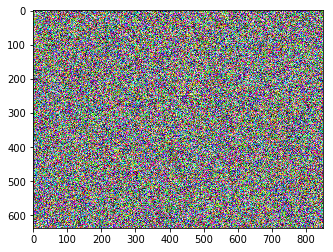

In [8]:
opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
plt.imshow(opt_img);

In [9]:
opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])

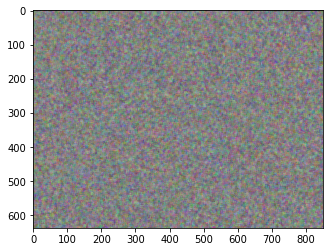

In [10]:
plt.imshow(opt_img);

In [11]:
opt_img = val_tfms(opt_img)/2
opt_img_v = V(opt_img[None], requires_grad=True)
opt_img_v.shape

torch.Size([1, 3, 288, 288])

In [12]:
m_vgg = nn.Sequential(*children(m_vgg)[:37])

In [13]:
targ_t = m_vgg(VV(img_tfm[None]))
targ_v = V(targ_t)
targ_t.shape

torch.Size([1, 512, 18, 18])

In [14]:
max_iter = 2000
show_iter = 100
optimizer = optim.LBFGS([opt_img_v], lr=0.5)

In [15]:
def actn_loss(x): return F.mse_loss(m_vgg(x), targ_v)*1000

In [16]:
def step(loss_fn):
    global n_iter
    optimizer.zero_grad()
    loss = loss_fn(opt_img_v)
    loss.backward()
    n_iter+=1
    if n_iter%show_iter==0: print(f'Iteration: n_iter, loss: {loss.data[0]}')
    return loss

In [17]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss))

Iteration: n_iter, loss: 0.4331847131252289
Iteration: n_iter, loss: 0.20806266367435455
Iteration: n_iter, loss: 0.13706226646900177
Iteration: n_iter, loss: 0.10421565175056458
Iteration: n_iter, loss: 0.08589307218790054
Iteration: n_iter, loss: 0.07497258484363556
Iteration: n_iter, loss: 0.06757710874080658
Iteration: n_iter, loss: 0.06217020004987717
Iteration: n_iter, loss: 0.05783573538064957
Iteration: n_iter, loss: 0.054727740585803986
Iteration: n_iter, loss: 0.052166491746902466
Iteration: n_iter, loss: 0.049655523151159286
Iteration: n_iter, loss: 0.04753679782152176
Iteration: n_iter, loss: 0.04582328721880913
Iteration: n_iter, loss: 0.044291816651821136
Iteration: n_iter, loss: 0.04286707565188408
Iteration: n_iter, loss: 0.04168573394417763
Iteration: n_iter, loss: 0.04063381627202034
Iteration: n_iter, loss: 0.03957816958427429
Iteration: n_iter, loss: 0.038614556193351746


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


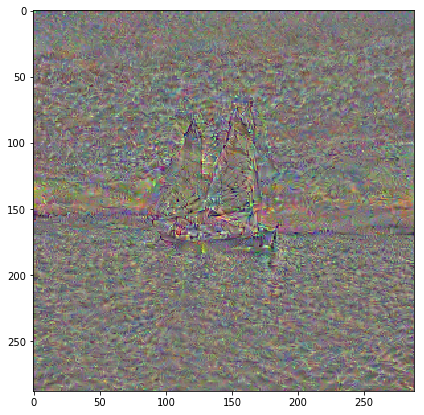

In [18]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

## forward hook

In [19]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def close(self): self.hook.remove()

In [20]:
m_vgg = to_gpu(vgg16(True)).eval()
set_trainable(m_vgg, False)

In [21]:
block_ends = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
block_ends

[5, 12, 22, 32, 42]

In [22]:
sf = SaveFeatures(children(m_vgg)[block_ends[3]])

In [23]:
def get_opt():
    opt_img = np.random.uniform(0, 1, size=img.shape).astype(np.float32)
    opt_img = scipy.ndimage.filters.median_filter(opt_img, [8,8,1])
    opt_img_v = V(val_tfms(opt_img/2)[None], requires_grad=True)
    return opt_img_v, optim.LBFGS([opt_img_v])

In [24]:
opt_img_v, optimizer = get_opt()

In [25]:
m_vgg(VV(img_tfm[None]))
targ_v = V(sf.features.clone())
targ_v.shape

torch.Size([1, 512, 36, 36])

In [26]:
def actn_loss2(x):
    m_vgg(x)
    out = V(sf.features)
    return F.mse_loss(out, targ_v)*1000

In [27]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,actn_loss2))

Iteration: n_iter, loss: 0.18151873350143433
Iteration: n_iter, loss: 0.08423329889774323
Iteration: n_iter, loss: 0.05517993122339249
Iteration: n_iter, loss: 0.0417405441403389
Iteration: n_iter, loss: 0.03409001976251602
Iteration: n_iter, loss: 0.029244113713502884
Iteration: n_iter, loss: 0.025837711989879608
Iteration: n_iter, loss: 0.023256395012140274
Iteration: n_iter, loss: 0.021267125383019447
Iteration: n_iter, loss: 0.019716400653123856
Iteration: n_iter, loss: 0.01840057037770748
Iteration: n_iter, loss: 0.017280809581279755
Iteration: n_iter, loss: 0.016313210129737854
Iteration: n_iter, loss: 0.0154673270881176
Iteration: n_iter, loss: 0.01472463272511959
Iteration: n_iter, loss: 0.014076943509280682
Iteration: n_iter, loss: 0.01351157110184431
Iteration: n_iter, loss: 0.013000440783798695
Iteration: n_iter, loss: 0.012528830207884312
Iteration: n_iter, loss: 0.012101288884878159


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


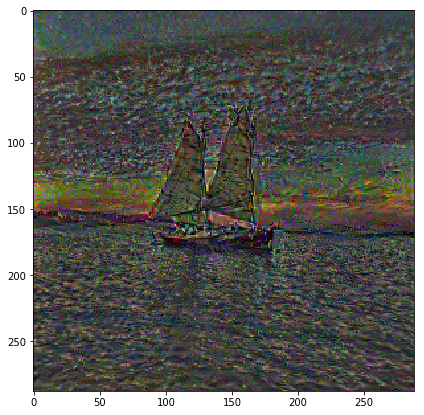

In [28]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [29]:
sf.close()

## Style match

In [30]:
# style_fn = PATH/'trainA'/'14397f6aaa8.jpg'
style_fn = PATH/'testA'/'9a019eb26a6.jpg'


In [31]:
style_img = open_image(style_fn)
style_img.shape, img.shape

((236, 236, 3), (638, 850, 3))

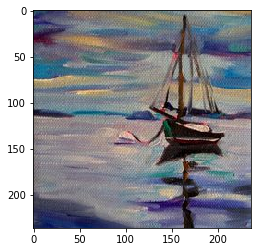

In [32]:
plt.imshow(style_img);

In [33]:
def scale_match(src, targ):
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    rat = max(h/sh,w/sw); rat
    res = cv2.resize(targ, (int(sw*rat), int(sh*rat)))
    return res[:h,:w]

In [34]:
style = scale_match(img, style_img)

((638, 850, 3), (638, 850, 3))

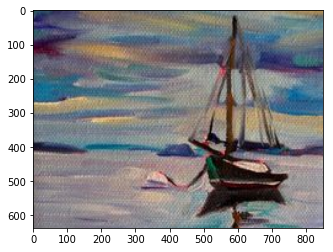

In [35]:
plt.imshow(style)
style.shape, img.shape

In [36]:
opt_img_v, optimizer = get_opt()

In [37]:
sfs = [SaveFeatures(children(m_vgg)[idx]) for idx in block_ends]

In [38]:
m_vgg(VV(img_tfm[None]))
targ_vs = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_vs]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [39]:
style_tfm = val_tfms(style_img)

In [40]:
m_vgg(VV(style_tfm[None]))
targ_styles = [V(o.features.clone()) for o in sfs]
[o.shape for o in targ_styles]

[torch.Size([1, 64, 288, 288]),
 torch.Size([1, 128, 144, 144]),
 torch.Size([1, 256, 72, 72]),
 torch.Size([1, 512, 36, 36]),
 torch.Size([1, 512, 18, 18])]

In [41]:
def gram(input):
        b,c,h,w = input.size()
        x = input.view(b*c, -1)
        return torch.mm(x, x.t())/input.numel()*1e6

def gram_mse_loss(input, target): return F.mse_loss(gram(input), gram(target))

In [42]:
def style_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    return sum(losses)

In [43]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,style_loss))

Iteration: n_iter, loss: 249.81686401367188
Iteration: n_iter, loss: 74.53701782226562
Iteration: n_iter, loss: 30.627382278442383
Iteration: n_iter, loss: 16.838699340820312
Iteration: n_iter, loss: 10.89016056060791
Iteration: n_iter, loss: 7.84710693359375
Iteration: n_iter, loss: 6.196547508239746
Iteration: n_iter, loss: 5.163610458374023
Iteration: n_iter, loss: 4.482324600219727
Iteration: n_iter, loss: 4.01525354385376
Iteration: n_iter, loss: 3.6898717880249023
Iteration: n_iter, loss: 3.447073459625244
Iteration: n_iter, loss: 3.2613182067871094
Iteration: n_iter, loss: 3.1180367469787598
Iteration: n_iter, loss: 2.999925136566162
Iteration: n_iter, loss: 2.9024553298950195
Iteration: n_iter, loss: 2.8153843879699707
Iteration: n_iter, loss: 2.7411279678344727
Iteration: n_iter, loss: 2.675248622894287
Iteration: n_iter, loss: 2.6188230514526367


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


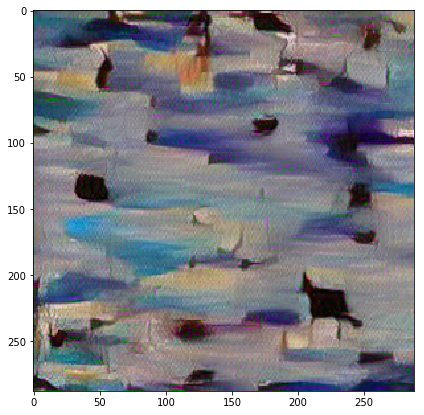

In [44]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(7,7))
plt.imshow(x);

In [45]:
# for sf in sfs: sf.close()

## Style transfer

In [46]:
opt_img_v, optimizer = get_opt()

In [47]:
def comb_loss(x):
    m_vgg(opt_img_v)
    outs = [V(o.features) for o in sfs]
    losses = [gram_mse_loss(o, s) for o,s in zip(outs, targ_styles)]
    cnt_loss   = F.mse_loss(outs[3], targ_vs[3])*1000000
    style_loss = sum(losses)
    return cnt_loss + style_loss

In [48]:
n_iter=0
while n_iter <= max_iter: optimizer.step(partial(step,comb_loss))

Iteration: n_iter, loss: 1324.662109375
Iteration: n_iter, loss: 953.933837890625
Iteration: n_iter, loss: 788.0326538085938
Iteration: n_iter, loss: 686.46435546875
Iteration: n_iter, loss: 627.9232788085938
Iteration: n_iter, loss: 592.7728271484375
Iteration: n_iter, loss: 569.4048461914062
Iteration: n_iter, loss: 551.9993896484375
Iteration: n_iter, loss: 538.2859497070312
Iteration: n_iter, loss: 527.472900390625
Iteration: n_iter, loss: 518.4591674804688
Iteration: n_iter, loss: 510.67608642578125
Iteration: n_iter, loss: 504.0644226074219
Iteration: n_iter, loss: 498.5884094238281
Iteration: n_iter, loss: 493.6212158203125
Iteration: n_iter, loss: 489.2303161621094
Iteration: n_iter, loss: 485.4331970214844
Iteration: n_iter, loss: 482.22625732421875
Iteration: n_iter, loss: 479.343017578125
Iteration: n_iter, loss: 476.7664794921875


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


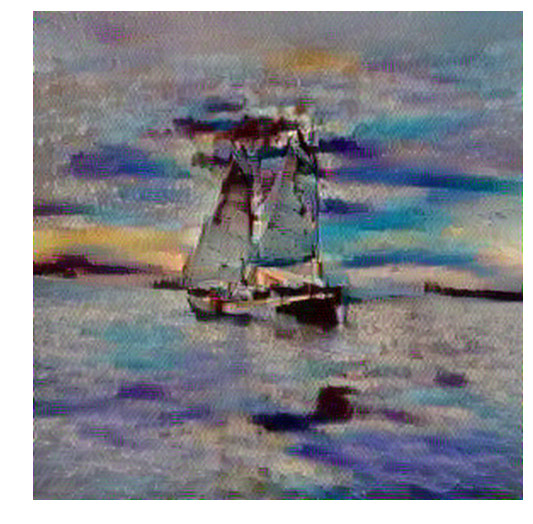

In [49]:
x = val_tfms.denorm(np.rollaxis(to_np(opt_img_v.data),1,4))[0]
plt.figure(figsize=(9,9))
plt.imshow(x, interpolation='lanczos')
plt.axis('off');

In [50]:
for sf in sfs: sf.close()